# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* the pdf with your answers
* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [38]:
# Python 3.6 or above is required
from collections import defaultdict
import gzip
import numpy as np
from pathlib import Path
from urllib.request import urlretrieve
import heapq
import string
import matplotlib.pyplot as plt 

In [39]:
PATH_TO_DATA = Path('data/')
# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
if not en_embeddings_path.exists():
    urlretrieve(
        'https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz',
        en_embeddings_path)
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urlretrieve(
        'https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz',
        fr_embeddings_path)

# 1) Monolingual (English) word embeddings 

In [40]:
class Word2Vec():

    def __init__(self, filepath, vocab_size=50000):
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}

    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz')
        words = []
        embeddings = []
        with gzip.open(filepath, 'rt') as f:  # Read compressed file directly
            next(f)  # Skip header
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                words.append(word)
                embeddings.append(np.fromstring(vec, sep=' '))
                if i == (vocab_size - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(words)))
        return np.array(words), np.vstack(embeddings)

    def encode(self, word):
        """
        Gets the encoding of the input word

        Parameters:
        word (str): Input word

        Returns:
        list: Embedding of the input word

        """
        idx = self.word2id.get(word, -1)
        if idx == -1:
            return np.zeros((self.embeddings.shape[1]))
            print(word, "is not in the vocabulary")
        return self.embeddings[idx]

    def most_similar(self, w, K=5):
        """
        Outputs a list of the K "closest" words to the input word w
        according to the embedding and the cosine similarity

        Parameters:
        w (str): Input word
        K (int): number of closest words (K>0)

        Returns:
        list: K closest words to the input
        """
        # K most similar words: self.score  -  np.argsort
        if K < 1:
            print("K should be strictly positive")
            return []
        if K > len(self.words):
            print("K should be lower than the size of the vocabulary")
            return []

        list_score = - np.ones((len(self.words)))
        for idx, w_vocab in enumerate(self.words):
            if w_vocab != w:
                list_score[idx] = self.score(w, w_vocab)

        if max(list_score) != -1:
            # Get the K best (largest) scores
            idx_best_words = np.argsort(list_score)[-K:]
            # reverse the list since the indexes
            # are following the decreasing sort order
            return self.words[idx_best_words][::-1]
        else:
            print('The input word is not in the vocabulary')
            return []

    def score(self, w1, w2):
        """
        Cosine similarity between embedding of words w1 and w2

        Parameters:
        w1 (str): Input word 1
        w2 (str): Input word 2

        Returns:
        float: Cosine similarity measure

        """
        # cosine similarity: np.dot  -  np.linalg.norm
        if w1 in self.words and w2 in self.words:
            emb1, emb2 = self.encode(w1), self.encode(w2)
            return np.dot(emb1, emb2) / \
                (np.linalg.norm(emb1) * np.linalg.norm(emb2))
        else:
            print("One of the input words is not in the vocabulary")
            return -1

In [41]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)

# You will be evaluated on the output of the following:
for word1, word2 in zip(('cat', 'cat', 'cat', 'Paris', 'Paris', 'Paris', 'Paris'), ('tree', 'dog', 'pet', 'France', 'Germany', 'baguette', 'donut')):
    print(word1, word2, word2vec.score(word1, word2))
for word in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(word2vec.most_similar(word))

Loaded 50000 pretrained word vectors
cat tree 0.26449754661654756
cat dog 0.7078641298542564
cat pet 0.6753313359976382
Paris France 0.6892958925806543
Paris Germany 0.4051242286737549
Paris baguette 0.29399958277802224
Paris donut -0.006588507552348003
['cats' 'kitty' 'kitten' 'feline' 'dog']
['dogs' 'puppy' 'pup' 'canine' 'pet']
['dog' 'cats' 'puppies' 'Dogs' 'pets']
['France' 'Parisian' 'Marseille' 'Brussels' 'Strasbourg']
['Austria' 'Europe' 'Berlin' 'Hamburg' 'Bavaria']


In [42]:
class BagOfWords():

    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.idf = {}

    def build_idf(self, sentences):
        """
        Build the IDF representation of each word
        
        
        Parameters:
        sentences (list): List of list of words
        
        Returns:
        dict: Dictionnary of word to IDF representations
        """
        # build the idf dictionary: associate each word to its idf value
        # -> idf = {word: idf_value, ...}
        N = len(sentences)

        # first pass to count unique occurences of words in each sentence
        for s in sentences:
            # clean the sentence and turn it into a list of words
            words = s.translate(
                str.maketrans('', '', string.punctuation)
                ).strip().lower().split(" ")
            words = np.unique(words)
            for word in words:
                self.idf[word] = self.idf.get(word, 0) + 1
        # second pass to compute the inverse frequencies
        for idx in self.idf.keys():
            self.idf[idx] = np.log(N / self.idf.get(idx, 1))

        return self.idf

    def encode(self, sentence, idf=None):
        """
        Encodes a sentence using the mean of its word vectors (with option to use idf weighting)


        Parameters:
        sentence (list): list of words
        idf (boolean): Decides whether to use idf weighting or not
        
        Returns:
        Mean of word reprensentations
        """
        # Takes a sentence as input, returns the sentence embedding

        # clean the sentence and turn it into a list of words
        words = sentence.translate(
            str.maketrans('', '', string.punctuation)
            ).strip().lower().split(" ")
        if idf is None:
            # mean of word vectors
            return np.mean(np.vstack(
                [self.word2vec.encode(word)
                 for word in words]), axis=0)
        else:
            if not self.idf:
                print("The idf weighting is not defined")
            # idf-weighted mean of word vectors
            return np.mean(np.vstack(
                [self.word2vec.encode(word) * idf.get(word, 0)
                 for word in words]), axis=0)

    def score(self, sentence1, sentence2, idf=None):
        """
        Computes the cosine similarity between two sentences
        
        
        Parameters:
        sentence1 (list): list of words
        sentence2 (list): list of words
        
        Returns:
        float: cosine similarity score
        
        """
        # cosine similarity: use np.dot & np.linalg.norm
        emb1, emb2 = self.encode(sentence1, idf), self.encode(sentence2, idf)
        return np.dot(emb1, emb2) / \
            (np.linalg.norm(emb1) * np.linalg.norm(emb2))

    def most_similar(self, sentence, sentences, idf=None, K=5):
        """
        Gets the most K most similar sentences
        
        Paramters:
        sentence: list of words to match
        sentences: list of list of words 
        
        Returns:
        list of K list of words closest to sentence 
        """
        # Return most similar sentences
        if K < 1:
            print("K should be strictly positive")
            return []
        if K > len(sentences):
            print("K should be lower than the total number of sentences")
            return []
        
        sentences = np.array(sentences)

        list_score = - np.ones((len(sentences)))
        for idx, sentence2 in enumerate(sentences):
            if sentence2 != sentence:
                list_score[idx] = self.score(sentence, sentence2, idf)

        idx_best_words = np.argsort(list_score)[-K:]
        return sentences[idx_best_words][::-1]

In [43]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

# Load sentences in "PATH_TO_DATA/sentences.txt"
filepath = PATH_TO_DATA / 'sentences.txt'
with open(filepath, 'r') as f:
    sentences = [line.strip('\n') for line in f]


# You will be evaluated on the output of the following:
print('\n\tAverage of word embeddings')
sentence1 = sentences[7]
sentence2 = sentences[13]
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2))
print()
my_sentence = sentences[10]
similar_sentences = sentence2vec.most_similar(my_sentence, sentences)  # BagOfWords-mean
print(my_sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

# Build idf scores for each word
idf = sentence2vec.build_idf(sentences)

print('\n\tidf weighted average of word embeddings')
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2, idf))
print()
similar_sentences = sentence2vec.most_similar(my_sentence, sentences, idf)  # BagOfWords-idf
print(my_sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

Loaded 50000 pretrained word vectors

	Average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.6412959133125586

1 smiling african american boy . 
1) 2 woman dancing while pointing . 
2) 5 women and 1 man are smiling for the camera . 
3) 3 males and 1 woman enjoying a sporting event 
4) 2 chinese people wearing traditional clothes 
5) a young boy and 2 girls open christmas presents . 

	idf weighted average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.6394533501689229

1 smiling african american boy . 
1) 1 man singing and 1 man playing a saxophone in a concert . 
2) two women and 1 man walking across the street . 
3) 2 guys facing away from camera , 1 girl smiling at camera with blue shirt , 1 guy with a beverage with a jacket on . 
4) 3 males and 1 woman enjoying a sporting event 
5) 5 women and 1 man are smiling fo

# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [46]:
class MultilingualWordAligner:
    
    def __init__(self, fr_word2vec, en_word2vec):
        self.fr_word2vec = fr_word2vec
        self.en_word2vec = en_word2vec
        self.aligned_fr_embeddings = self.get_aligned_fr_embeddings()
        
    def get_aligned_fr_embeddings(self):
        """
        Gets the french embeddings in the same vector space as the english embeddings
        
        Parameters:
        None
        
        Returns:
        np.array: Aligned French embeddings
        """
        # 1 - Get words that appear in both vocabs (= identical character strings)
        #     Use it to create the matrix X (emb_dim, vocab_size) and Y (emb_dim, vocab_size) (of embeddings for these words)
        
        # Binary intersection of dictionary keys
        shared_keys = self.fr_word2vec.word2id.keys() & self.en_word2vec.word2id.keys()
        X = np.vstack([self.fr_word2vec.encode(key) for key in shared_keys]).T
        Y = np.vstack([self.en_word2vec.encode(key) for key in shared_keys]).T
        assert X.shape[0] == 300 and Y.shape[0] == 300
        assert X.shape[1] == Y.shape[1]
        
        # 2 - Solve the Procrustes using the numpy package and: np.linalg.svd() and get the optimal W
        #     Now self.fr_word2vec.embeddings * W.transpose() is in the same space as en_word2vec.embeddings
        U,Sig,Vt = np.linalg.svd(Y@X.T)
        W = U@Vt
        assert W.shape == (300, 300)
        
        return np.matmul(fr_word2vec.embeddings, W.transpose())
        
    def get_closest_english_words(self, fr_word, k=3):
        """
        Gets the most K most similar english words to the french input word
        
        Paramters:
        fr_word (str): word to match
        k (int): number of words to match 
        
        Returns:
        list of K list of words closest to sentence 
        """
        # 3 - Return the top k English nearest neighbors to the input French word
        if k < 1:
            print("K should be strictly positive")
            return []
        if k > len(self.en_word2vec.embeddings):
            print("K should be lower than the total number of english words")
            return []
        
        idx = self.fr_word2vec.word2id[fr_word]
        fr_emb = self.aligned_fr_embeddings[idx]
        en_embs = self.en_word2vec.embeddings
        
        scores = en_embs @ fr_emb.reshape((-1,1))
        scores /= np.linalg.norm(fr_emb)
        scores /= np.linalg.norm(en_embs,axis=1)[:,None]
        scores = scores.ravel()
        
        return [self.en_word2vec.id2word[x] for x in scores.argsort()[-k:]][::-1]

In [47]:
fr_word2vec = Word2Vec(fr_embeddings_path, vocab_size=50000)
en_word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
multilingual_word_aligner = MultilingualWordAligner(fr_word2vec, en_word2vec)

# You will be evaluated on the output of the following:
fr_words = ['chat', 'chien', 'voiture', 'zut']
k = 3
for fr_word in fr_words:
    print('-' * 10)
    print(f'fr: "{fr_word}"')
    en_words = multilingual_word_aligner.get_closest_english_words(fr_word, k=3)
    for en_word in en_words:
        print(f'en: "{en_word}"')

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors
----------
fr: "chat"
en: "cat"
en: "kitten"
en: "kitty"
----------
fr: "chien"
en: "dog"
en: "cat"
en: "pet"
----------
fr: "voiture"
en: "car"
en: "vehicle"
en: "automobile"
----------
fr: "zut"
en: "oops"
en: "Ah"
en: "ah"


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [48]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

def get_data(file):
    """
    Get the data from the file
    
    Parameters:
    file (file_object): file to read the data from
    
    Returns:
    X (list): data points
    y (list): labels
    """
    X = []
    y = []
    for line in file:
        y.append(int(line[0]))
        X.append(line[2:])
    return X,y

with open(train_filepath,"r") as f:
    train_X, train_y = get_data(f)
with open(dev_filepath,"r") as f:
    dev_X, dev_y = get_data(f)
with open(test_filepath,"r") as f:
    test_X = []
    for line in f:
        test_X.append(line)
    
print(np.unique(train_y,return_counts=True))

(array([0, 1, 2, 3, 4]), array([1092, 2218, 1624, 2322, 1288]))


In [49]:
# 2 - Encode sentences with the BoV model above

word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
bow = BagOfWords(word2vec)
idf = bow.build_idf(train_X)

train_X_idf = np.vstack([bow.encode(line,idf=idf) for line in train_X]) 
dev_X_idf = np.vstack([bow.encode(line,idf=idf) for line in dev_X])  
test_X_idf = np.vstack([bow.encode(line,idf=idf) for line in test_X])  

train_X = np.vstack([bow.encode(line,idf=None) for line in train_X]) 
dev_X = np.vstack([bow.encode(line,idf=None) for line in dev_X])  
test_X = np.vstack([bow.encode(line,idf=None) for line in test_X])  

print(train_X.shape)

Loaded 50000 pretrained word vectors
(8544, 300)


Without IDF
Inverse Regularization strength= 0.001
dev acc: 0.2561307901907357
train acc: 0.273876404494382
Inverse Regularization strength= 0.0023101297000831605
dev acc: 0.27974568574023617
train acc: 0.2839419475655431
Inverse Regularization strength= 0.005336699231206312
dev acc: 0.29427792915531337
train acc: 0.30114700374531833
Inverse Regularization strength= 0.012328467394420659
dev acc: 0.30517711171662126
train acc: 0.3160112359550562
Inverse Regularization strength= 0.02848035868435802
dev acc: 0.32697547683923706
train acc: 0.33497191011235955
Inverse Regularization strength= 0.06579332246575682
dev acc: 0.35240690281562215
train acc: 0.3527621722846442
Inverse Regularization strength= 0.1519911082952933
dev acc: 0.3614895549500454
train acc: 0.37511704119850187
Inverse Regularization strength= 0.3511191734215131
dev acc: 0.3787465940054496
train acc: 0.39688670411985016
Inverse Regularization strength= 0.8111308307896873
dev acc: 0.3814713896457766
train acc: 0.41889044943

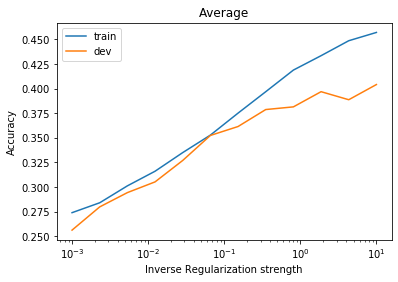

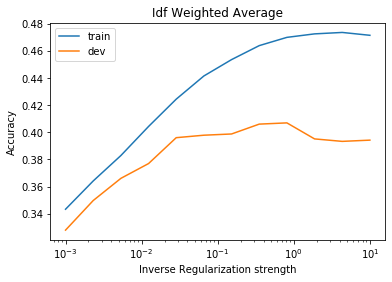

In [50]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
#     In the paper, the accuracy for average of word vectors is 32.7%
#     (VecAvg, table 1, https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

from sklearn.linear_model import LogisticRegression

regs = np.logspace(-3,1,12)
scores = np.zeros((2,len(regs)))

print("Without IDF")
for idx, reg in enumerate(regs):
    lr = LogisticRegression(C=reg, solver="lbfgs", multi_class="auto", max_iter=5000)
    lr.fit(train_X, train_y)
    scores[0,idx] = lr.score(train_X, train_y)
    scores[1,idx] = lr.score(dev_X, dev_y)
    print("Inverse Regularization strength=", reg)
    print("dev acc:", scores[1, idx])
    print("train acc:", scores[0, idx])
    
print("\nWith IDF")
scores_idf = np.zeros((2,len(regs)))
for idx, reg in enumerate(regs):
    lr = LogisticRegression(C=reg, solver="lbfgs", multi_class="auto", max_iter=5000)
    lr.fit(train_X_idf, train_y)
    scores_idf[0, idx] = lr.score(train_X_idf, train_y)
    scores_idf[1, idx] = lr.score(dev_X_idf, dev_y)
    print("Inverse Regularization strength=", reg)
    print("dev acc:", scores_idf[1, idx])
    print("train acc:", scores_idf[0, idx])
    
plt.figure()
plt.plot(regs, scores[0],label="train")
plt.plot(regs, scores[1],label="dev")
plt.xscale("log")
plt.xlabel("Inverse Regularization strength")
plt.ylabel("Accuracy")
plt.title("Average")
plt.legend()

plt.figure()
plt.plot(regs, scores_idf[0],label="train")
plt.plot(regs, scores_idf[1],label="dev")
plt.xscale("log")
plt.xlabel("Inverse Regularization strength")
plt.ylabel("Accuracy")
plt.title("Idf Weighted Average")
plt.legend()
plt.show()

In [51]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

lr = LogisticRegression(C=regs[np.argmax(scores)],solver="lbfgs",multi_class="auto",max_iter=1000)
lr.fit(train_X_idf,train_y)

print("train acc:",lr.score(train_X_idf, train_y))
print("dev acc:",lr.score(dev_X_idf, dev_y))

with open("logreg_bov_y_test_sst.txt","w") as f:
    y_pred = lr.predict(test_X_idf)
    for y in y_pred:
        f.write(str(y)+"\n")

train acc: 0.4714419475655431
dev acc: 0.3941871026339691


In [62]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

# Check best min_decrease value
gini_regs = np.logspace(-5,-2,12)
gini_scores = np.zeros((2,len(gini_regs)))
for idx, reg in enumerate(gini_regs):
    clf = RandomForestClassifier(min_impurity_decrease=reg, n_estimators=100, max_depth=15)
    clf.fit(train_X_idf, train_y)
    gini_scores[0, idx] = clf.score(train_X_idf, train_y)
    gini_scores[1, idx] = clf.score(dev_X_idf, dev_y)
    print("Minimum Gini Impurity decrease=", reg, "\t gives dev accuracy:", gini_scores[1, idx])
    
print()

# Check best max_depth value
depth_regs = np.linspace(3,100,10)
depth_scores = np.zeros((2,len(depth_regs)))
for idx, reg in enumerate(depth_regs):
    clf = RandomForestClassifier(min_impurity_decrease=0.001, n_estimators=100, max_depth=int(reg))
    clf.fit(train_X_idf, train_y)
    depth_scores[0, idx] = clf.score(train_X_idf, train_y)
    depth_scores[1, idx] = clf.score(dev_X_idf, dev_y)
    print("Max depth=", reg, "\t gives dev accuracy:", depth_scores[1, idx])

print()

# Check best min_samples_split value
split_regs = np.linspace(1,20,15)
split_scores = np.zeros((2,len(split_regs)))
for idx, reg in enumerate(split_regs):
    clf = RandomForestClassifier(min_impurity_decrease=0.001, n_estimators=100, max_depth=int(reg))
    clf.fit(train_X_idf, train_y)
    split_scores[0, idx] = clf.score(train_X_idf, train_y)
    split_scores[1, idx] = clf.score(dev_X_idf, dev_y)
    print("Min split=", reg, "\t gives dev accuracy:", split_scores[1, idx])

    
scores = np.zeros(2)
clf = RandomForestClassifier(n_estimators=100, 
                             min_impurity_decrease=gini_regs[np.argmax(gini_scores)], 
                             max_depth=int(depth_regs[np.argmax(depth_scores)]),
                             min_samples_split=int(split_regs[np.argmax(split_scores)]))
clf.fit(train_X_idf, train_y)
scores[0] = clf.score(train_X_idf, train_y)
scores[1] = clf.score(dev_X_idf, dev_y)

print(scores[0])
print(scores[1])

with open("XXX_bov_y_test_sst.txt","w") as f:
    y_pred = svm.predict(test_X_idf)
    for y in y_pred:
        f.write(str(y)+"\n")

Minimum Gini Impurity decrease= 1e-05 	 gives dev accuracy: 0.37329700272479566
Minimum Gini Impurity decrease= 1.873817422860383e-05 	 gives dev accuracy: 0.3405994550408719
Minimum Gini Impurity decrease= 3.511191734215127e-05 	 gives dev accuracy: 0.3542234332425068
Minimum Gini Impurity decrease= 6.579332246575683e-05 	 gives dev accuracy: 0.35967302452316074
Minimum Gini Impurity decrease= 0.0001232846739442066 	 gives dev accuracy: 0.37783832879200724
Minimum Gini Impurity decrease= 0.0002310129700083158 	 gives dev accuracy: 0.38056312443233425
Minimum Gini Impurity decrease= 0.0004328761281083057 	 gives dev accuracy: 0.3614895549500454
Minimum Gini Impurity decrease= 0.0008111308307896872 	 gives dev accuracy: 0.37057220708446864
Minimum Gini Impurity decrease= 0.0015199110829529332 	 gives dev accuracy: 0.3333333333333333
Minimum Gini Impurity decrease= 0.002848035868435799 	 gives dev accuracy: 0.33242506811989103
Minimum Gini Impurity decrease= 0.005336699231206307 	 gives 

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [6]:
import tensorflow as tf

In [21]:
# 1 - Using the same dataset, transform text to integers using tf.keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

def get_data2(file, is_test=False):
    """
    Gets the data and tranform it into one-hot encoding
    
    Parameters:
    file (file object): file to read the data from
    is_test (boolean): whether we are reading test data or not

    Returns:
    X (list): data points
    y (list): labels
    """
    X = []
    y = []
    
    for line in file:
        if is_test:
            X.append(tf.keras.preprocessing.text.one_hot(line,n=10000))
        else:
            y.append(int(line[0]))
            X.append(tf.keras.preprocessing.text.one_hot(line[2:],n=10000))
    if not is_test:
        y = tf.keras.utils.to_categorical(y)
        
    return X,y

with open(train_filepath,"r") as f:
    train_X, train_y = get_data2(f)
with open(dev_filepath,"r") as f:
    dev_X, dev_y = get_data2(f)
with open(test_filepath,"r") as f:
    test_X, _ = get_data2(f, is_test=True)

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [22]:
# 2 - Pad your sequences using tf.keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

train_X = tf.keras.preprocessing.sequence.pad_sequences(train_X, maxlen=50)
dev_X = tf.keras.preprocessing.sequence.pad_sequences(dev_X, maxlen=50)
test_X = tf.keras.preprocessing.sequence.pad_sequences(test_X, maxlen=50)

## 4.2 - Design and train your model

In [23]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.


# ADAPT CODE BELOW


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Activation

embed_dim  = 256  # word embedding dimension
nhid       = 128  # number of hidden units in the LSTM
vocab_size = 20000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(nhid, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(n_classes, activation='softmax',
               kernel_regularizer=tf.keras.regularizers.l2(0.1)))

In [24]:
# 4 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 256)         12800000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 256)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 12,997,765
Trainable params: 12,997,765
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)

# ADAPT CODE BELOW
bs = 64
n_epochs = 10

history = model.fit(train_X, train_y, batch_size=bs, epochs=n_epochs, validation_data=(dev_X, dev_y))

Train on 8544 samples, validate on 1101 samples
Epoch 1/20
8544/8544 [==============================] - 34s 4ms/sample - loss: 2.0268 - acc: 0.2636 - val_loss: 1.6948 - val_acc: 0.2534
Epoch 2/20
8544/8544 [==============================] - 34s 4ms/sample - loss: 1.6173 - acc: 0.2750 - val_loss: 1.5823 - val_acc: 0.2534
Epoch 3/20
8544/8544 [==============================] - 31s 4ms/sample - loss: 1.5756 - acc: 0.2708 - val_loss: 1.5785 - val_acc: 0.2534
Epoch 4/20
8544/8544 [==============================] - 31s 4ms/sample - loss: 1.5718 - acc: 0.2685 - val_loss: 1.5791 - val_acc: 0.2625
Epoch 5/20
8544/8544 [==============================] - 33s 4ms/sample - loss: 1.5697 - acc: 0.2707 - val_loss: 1.5727 - val_acc: 0.2625
Epoch 6/20
8544/8544 [==============================] - 36s 4ms/sample - loss: 1.5644 - acc: 0.2865 - val_loss: 1.5730 - val_acc: 0.2561
Epoch 7/20
8544/8544 [==============================] - 36s 4ms/sample - loss: 1.5435 - acc: 0.3011 - val_loss: 1.5897 - val_acc: 

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


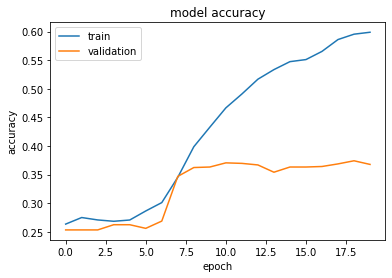

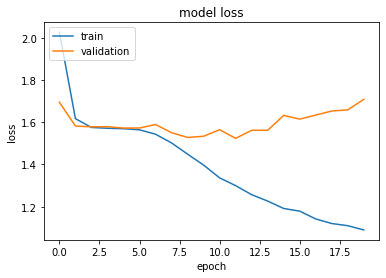

In [26]:
# 6 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

with open("logreg_lstm_y_test_sst.txt","w+") as f:
    y_pred = np.argmax(model.predict(test_X),1)
    for y in y_pred:
        f.write(str(y)+"\n")

## 4.3 - innovate !

Loaded 50000 pretrained word vectors
Train on 8544 samples, validate on 1101 samples
Epoch 1/150
8544/8544 [==============================] - 8s 934us/step - loss: 1.8878 - acc: 0.2548 - val_loss: 1.7428 - val_acc: 0.2761
Epoch 2/150
8544/8544 [==============================] - 7s 781us/step - loss: 1.6758 - acc: 0.2879 - val_loss: 1.6228 - val_acc: 0.2698
Epoch 3/150
8544/8544 [==============================] - 6s 716us/step - loss: 1.5951 - acc: 0.2985 - val_loss: 1.5655 - val_acc: 0.3161
Epoch 4/150
8544/8544 [==============================] - 6s 691us/step - loss: 1.5574 - acc: 0.3150 - val_loss: 1.5248 - val_acc: 0.3315
Epoch 5/150
8544/8544 [==============================] - 6s 681us/step - loss: 1.5337 - acc: 0.3254 - val_loss: 1.5146 - val_acc: 0.3442
Epoch 6/150
8544/8544 [==============================] - 6s 668us/step - loss: 1.5159 - acc: 0.3406 - val_loss: 1.4859 - val_acc: 0.3442
Epoch 7/150
8544/8544 [==============================] - 6s 702us/step - loss: 1.4988 - acc: 

Epoch 60/150
8544/8544 [==============================] - 6s 658us/step - loss: 1.2862 - acc: 0.4431 - val_loss: 1.2910 - val_acc: 0.4323
Epoch 61/150
8544/8544 [==============================] - 6s 664us/step - loss: 1.2802 - acc: 0.4465 - val_loss: 1.2776 - val_acc: 0.4441
Epoch 62/150
8544/8544 [==============================] - 7s 765us/step - loss: 1.2742 - acc: 0.4374 - val_loss: 1.2803 - val_acc: 0.4405
Epoch 63/150
8544/8544 [==============================] - 6s 745us/step - loss: 1.2788 - acc: 0.4424 - val_loss: 1.2833 - val_acc: 0.4296
Epoch 64/150
8544/8544 [==============================] - 6s 725us/step - loss: 1.2787 - acc: 0.4443 - val_loss: 1.2757 - val_acc: 0.4423
Epoch 65/150
8544/8544 [==============================] - 6s 696us/step - loss: 1.2689 - acc: 0.4395 - val_loss: 1.2811 - val_acc: 0.4378
Epoch 66/150
8544/8544 [==============================] - 6s 680us/step - loss: 1.2677 - acc: 0.4465 - val_loss: 1.2722 - val_acc: 0.4441
Epoch 67/150
8544/8544 [==========

8544/8544 [==============================] - 5s 599us/step - loss: 1.1835 - acc: 0.4963 - val_loss: 1.2755 - val_acc: 0.4623
Epoch 120/150
8544/8544 [==============================] - 5s 590us/step - loss: 1.1880 - acc: 0.4929 - val_loss: 1.2696 - val_acc: 0.4541
Epoch 121/150
8544/8544 [==============================] - 5s 589us/step - loss: 1.1870 - acc: 0.4802 - val_loss: 1.2858 - val_acc: 0.4450
Epoch 122/150
8544/8544 [==============================] - 5s 590us/step - loss: 1.1835 - acc: 0.4896 - val_loss: 1.2833 - val_acc: 0.4587
Epoch 123/150
8544/8544 [==============================] - 5s 593us/step - loss: 1.1723 - acc: 0.5035 - val_loss: 1.2844 - val_acc: 0.4587
Epoch 124/150
8544/8544 [==============================] - 5s 598us/step - loss: 1.1727 - acc: 0.5041 - val_loss: 1.2726 - val_acc: 0.4550
Epoch 125/150
8544/8544 [==============================] - 5s 601us/step - loss: 1.1747 - acc: 0.4909 - val_loss: 1.2895 - val_acc: 0.4496
Epoch 126/150
8544/8544 [================

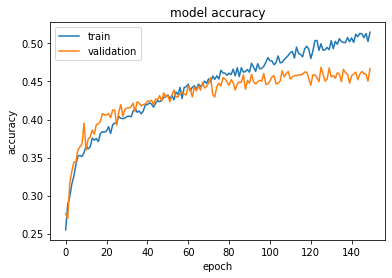

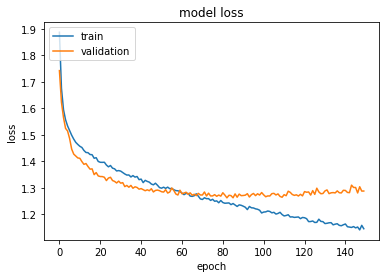

In [33]:
# 7 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation,Dropout,Conv1D,Flatten
from keras.layers import Bidirectional 
from keras.optimizers import RMSprop
from keras import backend as K
from keras.utils import to_categorical
from keras.preprocessing import text
import keras

train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

w2v = Word2Vec(en_embeddings_path, vocab_size=50000)

def get_data3(file, is_test=False):
    X = []
    y = []
    
    for line in file:
        if is_test:
            words = line.translate(str.maketrans('', '', string.punctuation)).strip().lower().split(" ")
            for idx, word in enumerate(words):
                words[idx] = w2v.word2id.get(word, 0)
            X.append(words)
        else:
            y.append(int(line[0]))
            words = line[2:].translate(str.maketrans('', '', string.punctuation)).strip().lower().split(" ")
            for idx, word in enumerate(words):
                words[idx] = w2v.word2id.get(word, 0)
            X.append(words)
    if not is_test:
        y = tf.keras.utils.to_categorical(y)
        
    return X,y

with open(train_filepath,"r") as f:
    train_X, train_y = get_data3(f)
with open(dev_filepath,"r") as f:
    dev_X, dev_y = get_data3(f)
with open(test_filepath,"r") as f:
    test_X, _ = get_data3(f, is_test=True)

    
padded_train_X = tf.keras.preprocessing.sequence.pad_sequences(train_X, maxlen=50)
padded_dev_X = tf.keras.preprocessing.sequence.pad_sequences(dev_X, maxlen=50)
padded_test_X = tf.keras.preprocessing.sequence.pad_sequences(test_X, maxlen=50)            
    
embed_dim  = 300  # word embedding dimension
vocab_size = len(w2v.embeddings)
nhid       = 64  # number of hidden units in the LSTM
n_classes  = 5    

    
model = Sequential()
model.add(Embedding(vocab_size, embed_dim, trainable = False, weights = [w2v.embeddings]))
model.add(LSTM(nhid, dropout=0.6, recurrent_dropout=0.6, recurrent_initializer = keras.initializers.Zeros()))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.6))
model.add(Dense(n_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.05)))

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)

bs = 128
n_epochs = 150

history = model.fit(padded_train_X, train_y, batch_size=bs, 
                    epochs=n_epochs, validation_data=(padded_dev_X, dev_y))

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

with open("XXX_XXX_y_test_sst.txt","w+") as f:
    y_pred = np.argmax(model.predict(padded_test_X),1)
    for y in y_pred:
        f.write(str(y)+"\n")
